In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

import xgboost as xgb


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
column_name=["MPG","Cylinders","Displacement","Horsepower","Weight","Acceleration","Model Year","Origin"]
data=pd.read_csv("/content/drive/MyDrive/auto+mpg (3)/auto-mpg.data", names = column_name, na_values = "?", comment= "\t", sep= " ", skipinitialspace= True)

target          0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


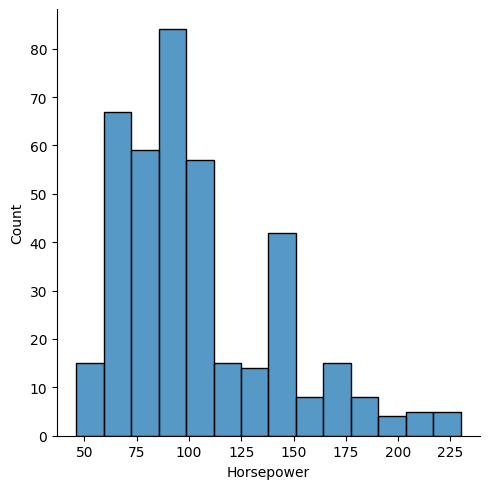

In [9]:
data = data.rename(columns = {"MPG":"target"})
describe = data.describe()
print(data.isna().sum()) #Eksik veri sayısının gösterimi
data["Horsepower"] = data["Horsepower"].fillna(data["Horsepower"].mean()) #Eksik verilerin ortalama değer ile doldurulması
sns.displot(data.Horsepower)
plt.show()

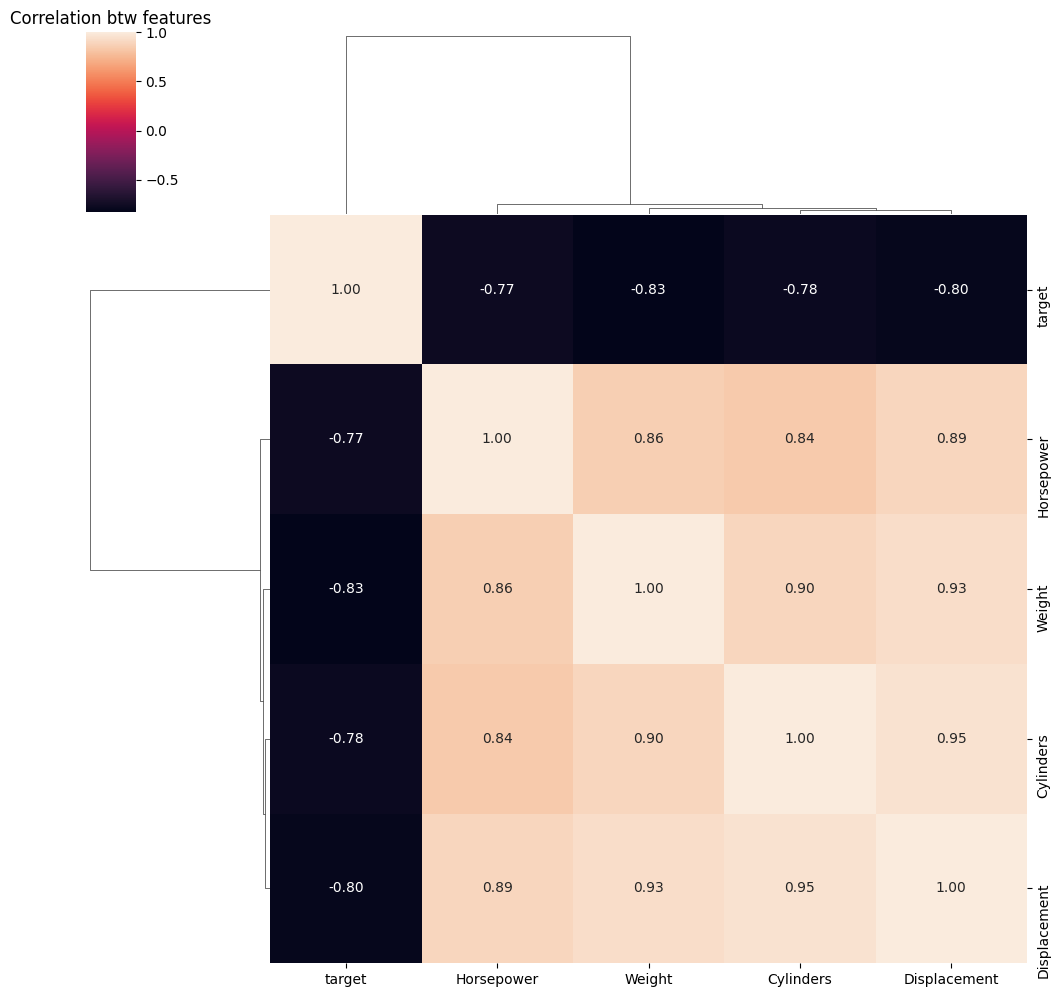

In [10]:
corr_matrix = data.corr()
threshold = 0.75
filtre = np.abs(corr_matrix["target"])>threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlation btw features")
plt.show()

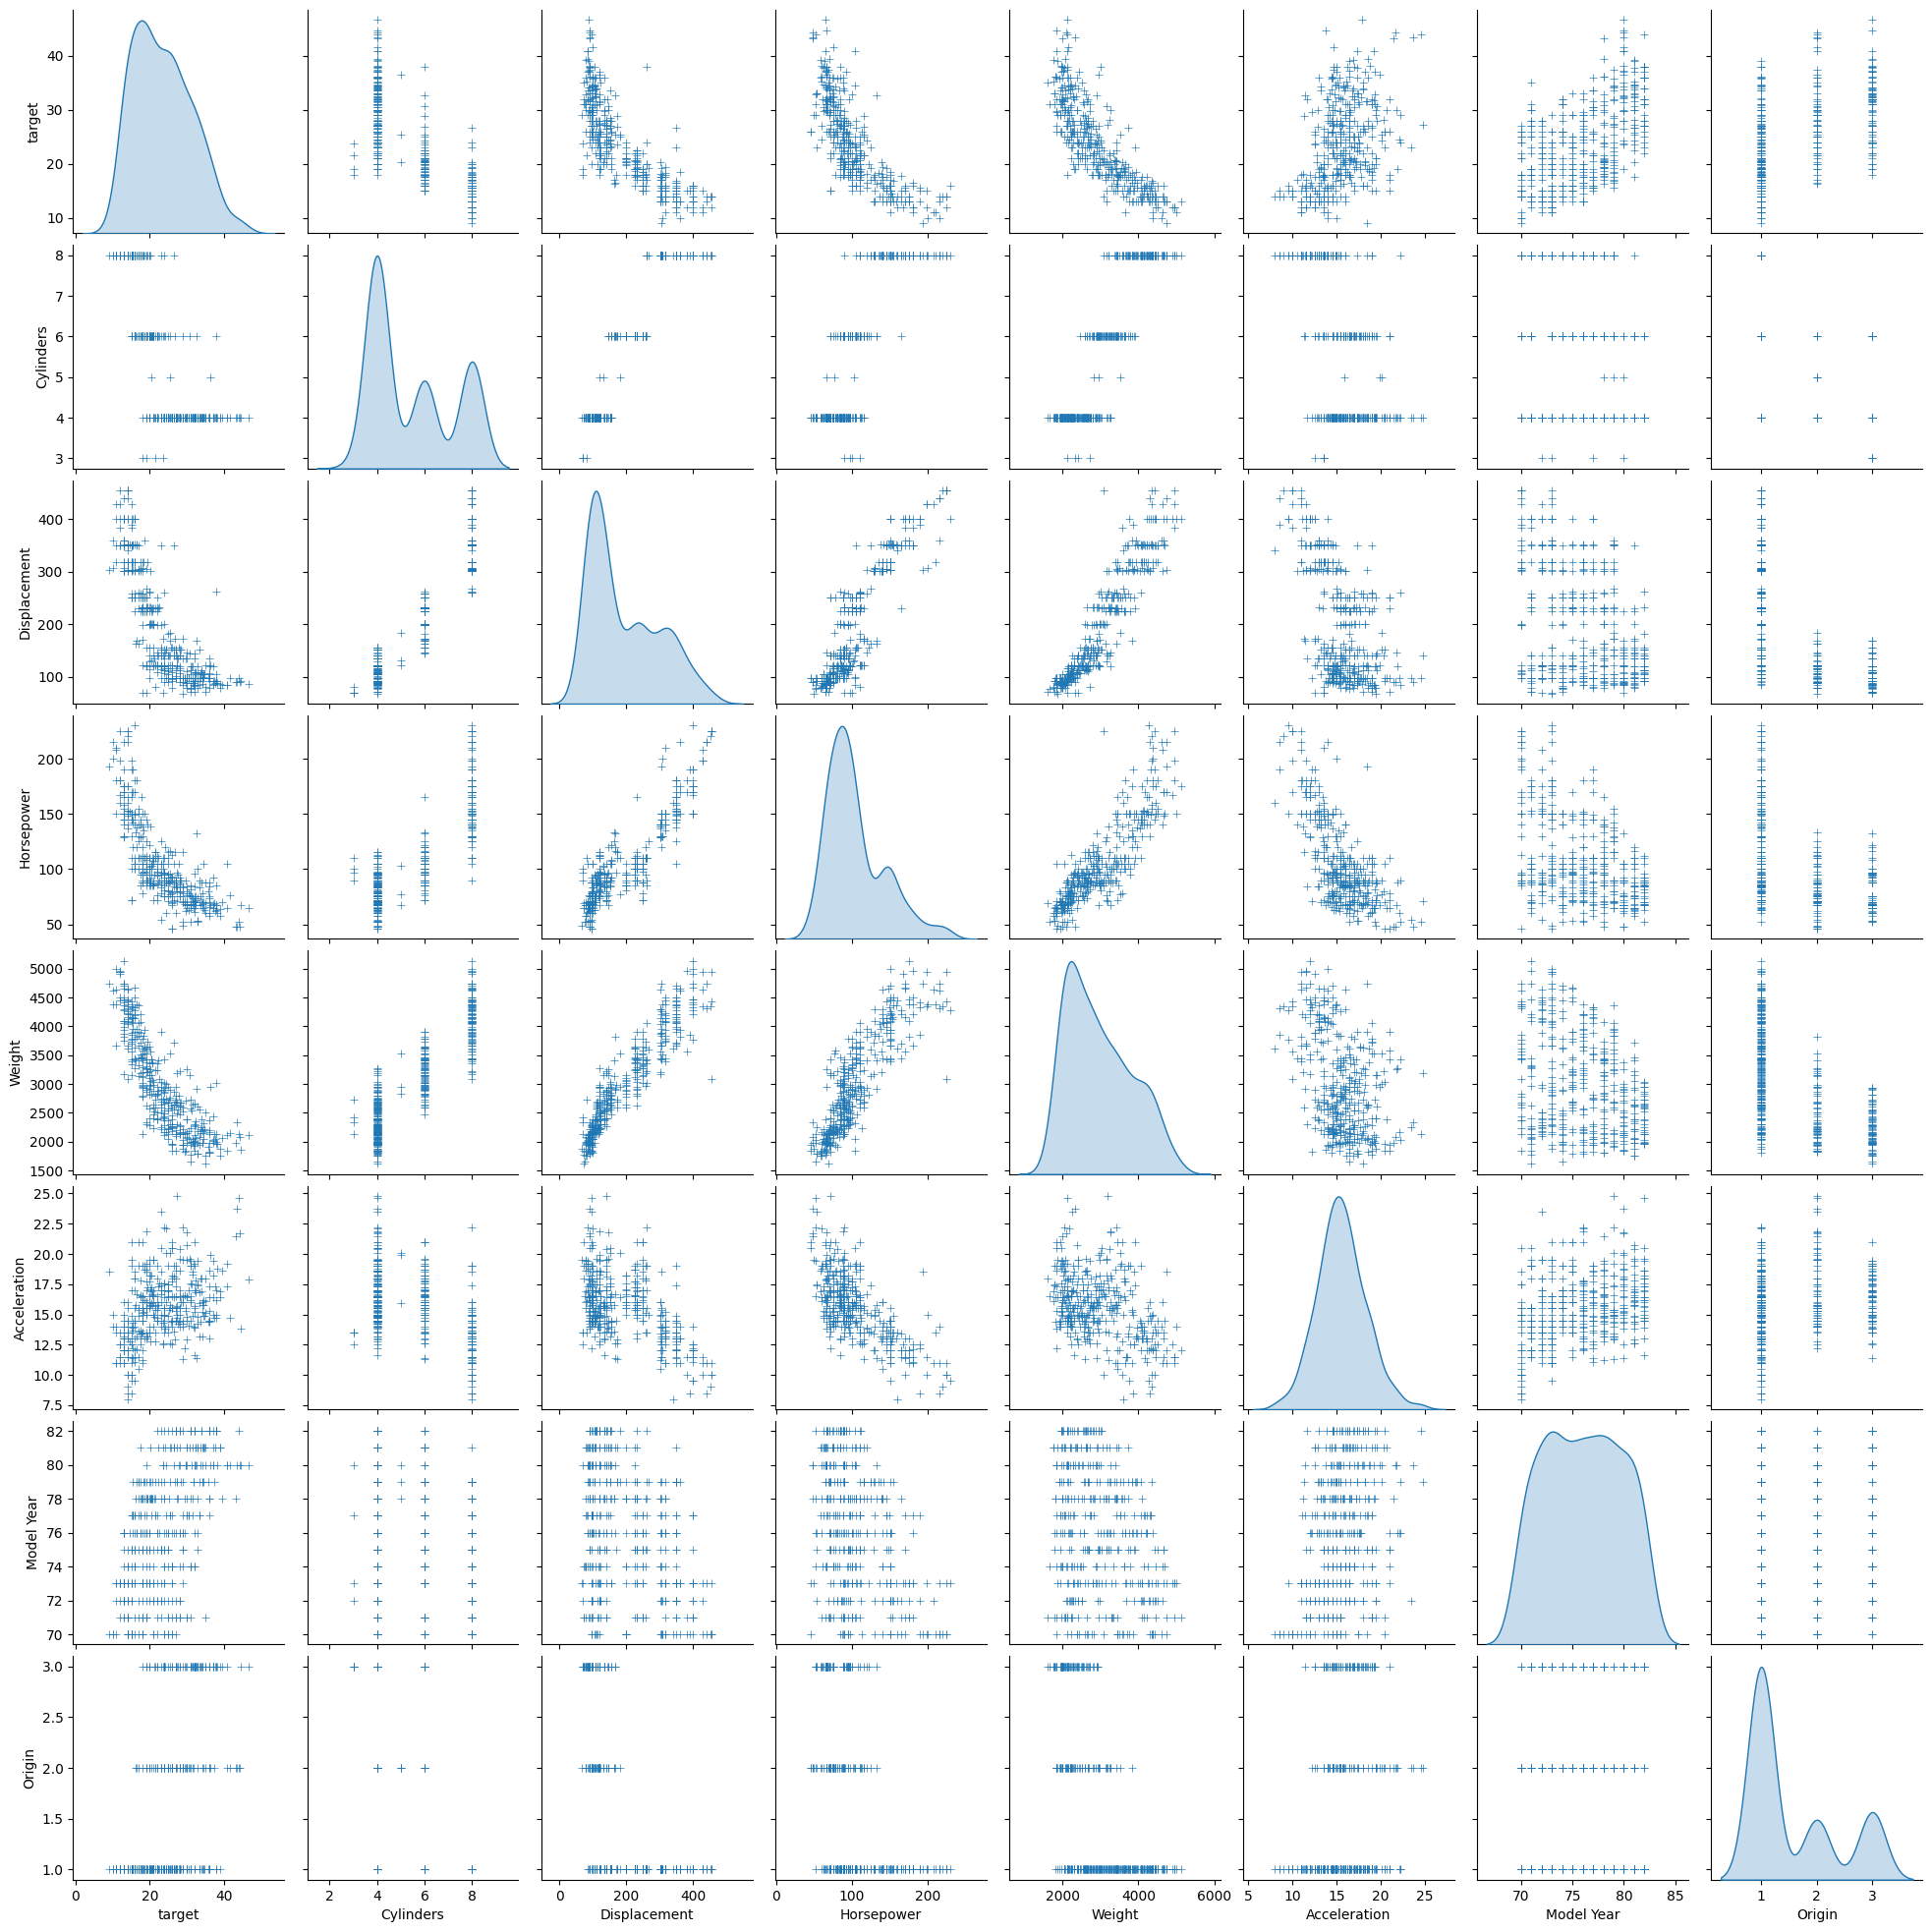

In [11]:
sns.pairplot(data, diag_kind = 'kde', markers = '+')
plt.show()

Cylinders
4    204
8    103
6     84
3      4
5      3
Name: count, dtype: int64


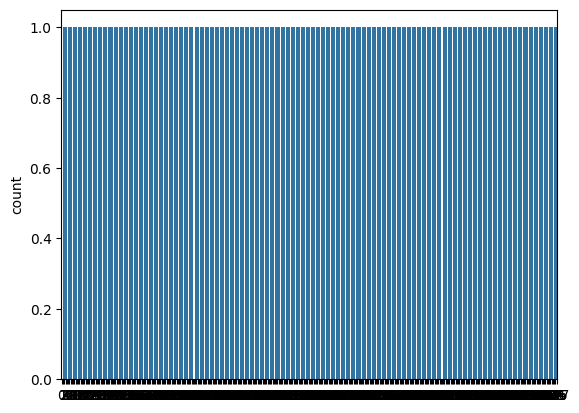

In [12]:
plt.figure()
sns.countplot(data["Cylinders"])
print(data["Cylinders"].value_counts())

Origin
1    249
3     79
2     70
Name: count, dtype: int64


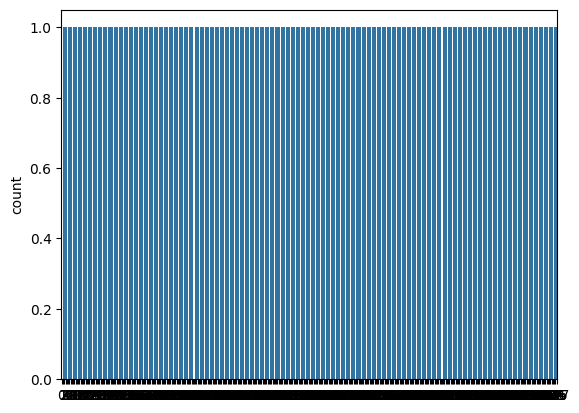

In [13]:
plt.figure()
sns.countplot(data["Origin"])
print(data["Origin"].value_counts())

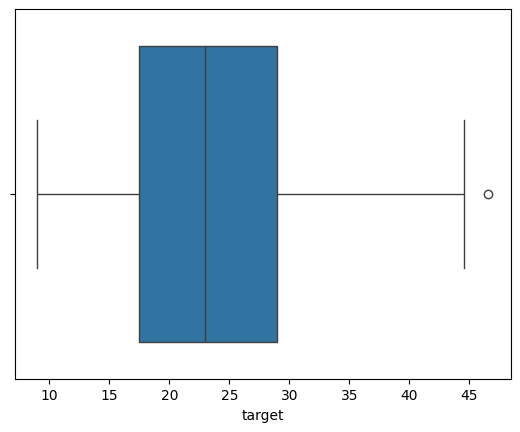

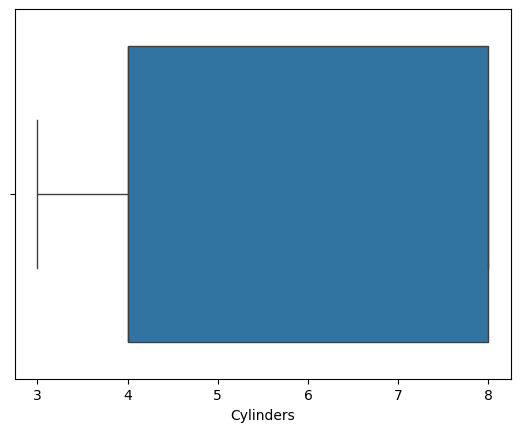

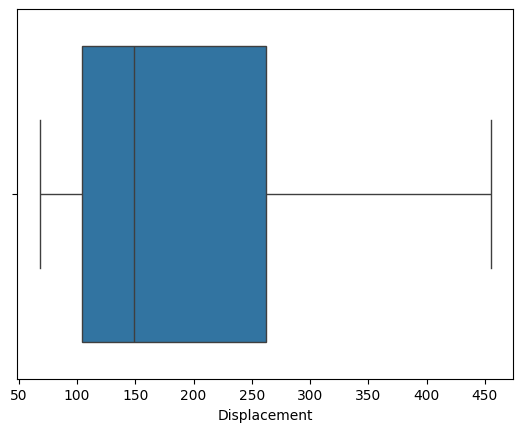

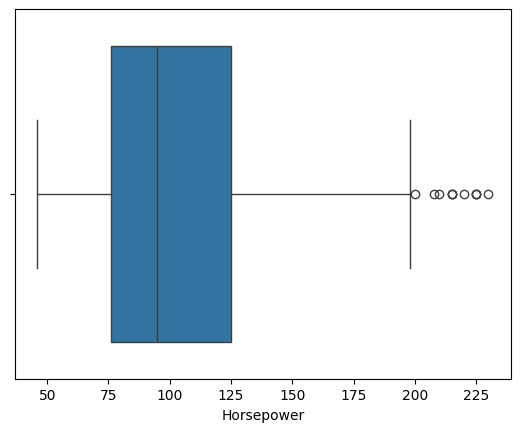

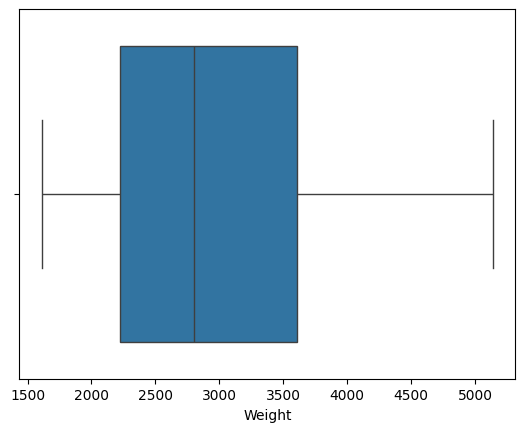

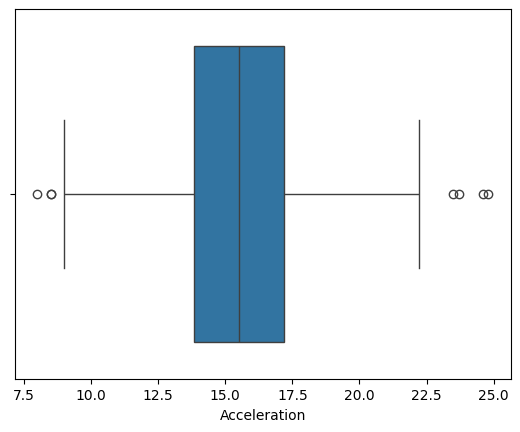

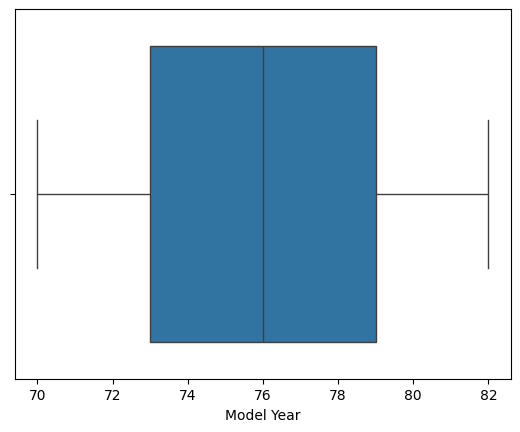

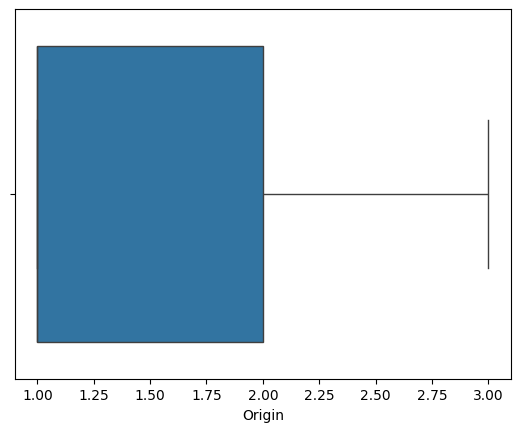

In [14]:
for c in data.columns:
    plt.figure()
    sns.boxplot(x = c, data = data, orient = "v")
    plt.show()

In [15]:
thr = 2
horsepower_desc = describe["Horsepower"]
q3_hp = horsepower_desc[6]
q1_hp = horsepower_desc[4]
IQR_hp = q3_hp - q1_hp
top_limit_hp = q3_hp + thr*IQR_hp
bottom_limit_hp = q1_hp - thr*IQR_hp
filter_hp_bottom = bottom_limit_hp < data["Horsepower"]
filter_hp_top = data["Horsepower"] < top_limit_hp
filter_hp = filter_hp_bottom & filter_hp_top

data = data[filter_hp]

In [16]:
acceleration_desc = describe["Acceleration"]
q3_acc = acceleration_desc[6]
q1_acc = acceleration_desc[4]
IQR_acc = q3_acc - q1_acc # q3 - q1
top_limit_acc = q3_acc + thr*IQR_acc
bottom_limit_acc = q1_acc - thr*IQR_acc
filter_acc_bottom = bottom_limit_acc < data["Acceleration"]
filter_acc_top= data["Acceleration"] < top_limit_acc
filter_acc = filter_acc_bottom & filter_acc_top

data = data[filter_acc] # remove Horsepower outliers

print(data)

     target  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0      18.0          8         307.0       130.0  3504.0          12.0   
1      15.0          8         350.0       165.0  3693.0          11.5   
2      18.0          8         318.0       150.0  3436.0          11.0   
3      16.0          8         304.0       150.0  3433.0          12.0   
4      17.0          8         302.0       140.0  3449.0          10.5   
..      ...        ...           ...         ...     ...           ...   
392    27.0          4         151.0        90.0  2950.0          17.3   
393    27.0          4         140.0        86.0  2790.0          15.6   
395    32.0          4         135.0        84.0  2295.0          11.6   
396    28.0          4         120.0        79.0  2625.0          18.6   
397    31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
0            70       1  
1            70       1  
2            70       1  
3      

<Figure size 640x480 with 0 Axes>

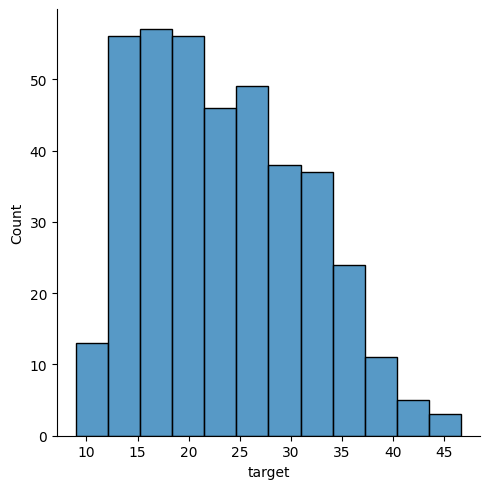

In [17]:
plt.figure()
sns.displot(data.target)
plt.show()

mu: 23.472405063291134, sigma = 7.756119546409932


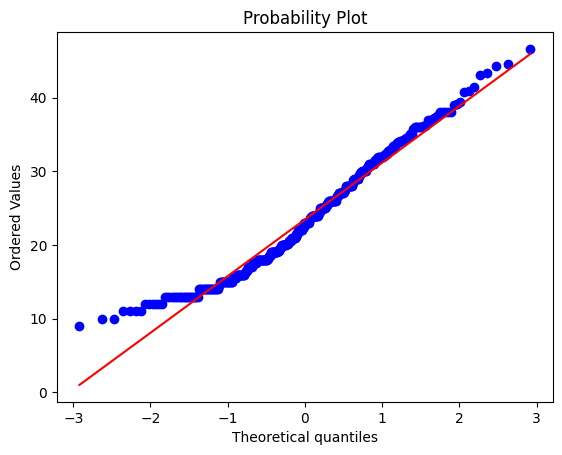

In [18]:
(mu,sigma)=norm.fit(data["target"])
print("mu: {}, sigma = {}".format(mu, sigma))

plt.figure()
stats.probplot(data["target"], plot=plt)
plt.show()

<Figure size 640x480 with 0 Axes>

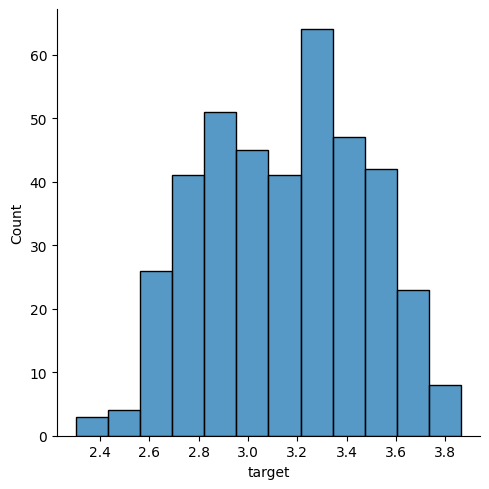

mu: 3.146474056830183, sigma = 0.3227569103044822


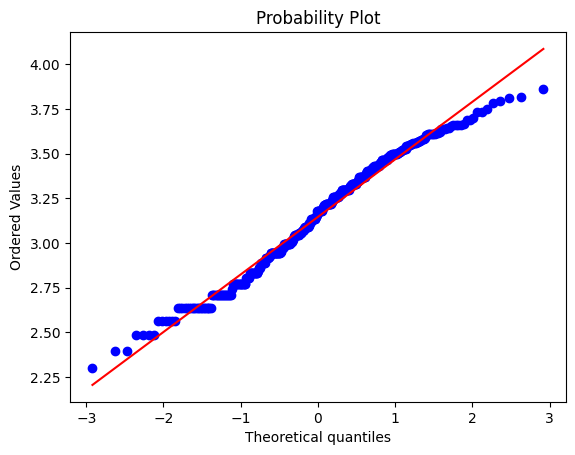

In [19]:
data["target"]=np.log1p(data["target"])

plt.figure()
sns.displot(data.target)
plt.show()

(mu,sigma)=norm.fit(data["target"])
print("mu: {}, sigma = {}".format(mu, sigma))

plt.figure()
stats.probplot(data["target"], plot=plt)
plt.show()

In [20]:
skewed_feats=data.apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
skewness=pd.DataFrame(skewed_feats, columns=["skewed"])
print(skewness)

                skewed
Horsepower    1.067743
Origin        0.923381
Displacement  0.714682
Weight        0.533226
Cylinders     0.523374
Acceleration  0.168986
Model Year    0.013098
target       -0.117687


In [21]:
data["Cylinders"]=data["Cylinders"].astype(str)
data["Origin"]=data["Origin"].astype(str)

data=pd.get_dummies(data)

In [22]:
x = data.drop(["target"], axis = 1)
y = data.target

In [23]:
test_size = 0.9
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = test_size, random_state = 42)

In [24]:
# Standardization
scaler = StandardScaler()  # RobustScaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# linear regression
lr = LinearRegression()
lr.fit(X_train, Y_train)
print("LR Coef: ",lr.coef_)
y_predicted_dummy = lr.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy)
print("Linear Regression MSE: ",mse)

LR Coef:  [-9.92705759e-02 -1.05006197e-01 -2.28689229e-02 -4.99057559e-02
  4.34952012e-02 -5.72828846e-02  4.72375426e-02 -3.46944695e-17
 -1.40612813e-02 -2.28840651e-02 -7.11143569e-03 -2.73464310e-02
  3.45783731e-02]
Linear Regression MSE:  0.020632204780133036


Ridge Coef:  [-0.07849695 -0.09734007 -0.03799319 -0.04613241  0.04520109 -0.0535352
  0.05108925  0.         -0.01455674 -0.02919833 -0.00857541 -0.02556196
  0.03459116]
Ridge Best Estimator:  Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Ridge MSE:  0.019725338010801202


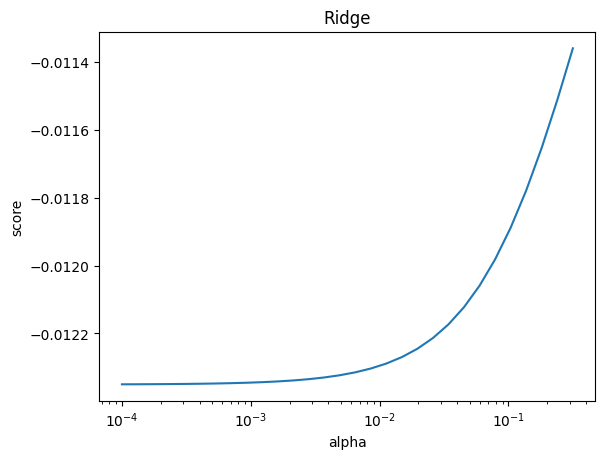

In [26]:
# Ridge Regression (L2)

ridge = Ridge(random_state = 42, max_iter = 10000)
alphas = np.logspace(-4,-0.5,30)

tuned_parameters = [{'alpha':alphas}]
n_folds = 5

clf = GridSearchCV(ridge, tuned_parameters, cv = n_folds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(X_train, Y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Ridge Coef: ",clf.best_estimator_.coef_)
ridge = clf.best_estimator_
print("Ridge Best Estimator: ", ridge)

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy)
print("Ridge MSE: ",mse)

plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")
plt.show()

Lasso Coef:  [-0.03758778 -0.08757891 -0.0646061  -0.02803523  0.0491826  -0.03359315
  0.071679    0.          0.         -0.01794883 -0.         -0.00408397
  0.04250482]
Lasso Best Estimator:  Lasso(alpha=0.004893900918477494, max_iter=10000, random_state=42)
Lasso MSE:  0.017521594770822498


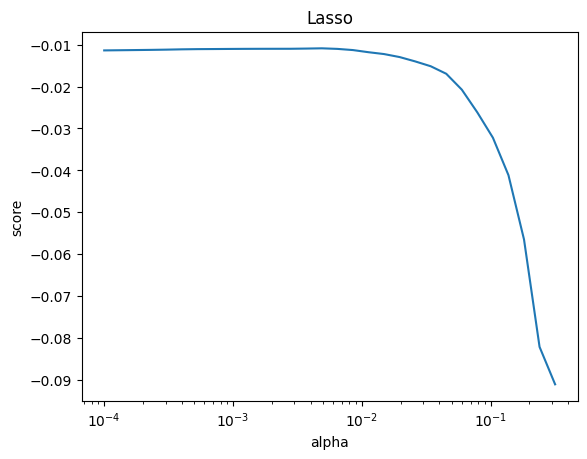

In [27]:
#Lasso Regression

lasso = Lasso(random_state=42, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error',refit=True)
clf.fit(X_train,Y_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print("Lasso Coef: ",clf.best_estimator_.coef_)
lasso = clf.best_estimator_
print("Lasso Best Estimator: ",lasso)

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("Lasso MSE: ",mse)

plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")
plt.show()

In [28]:
#ElasticNet

parametersGrid = {"alpha": alphas,
                  "l1_ratio": np.arange(0.0, 1.0, 0.05)}

eNet = ElasticNet(random_state=42, max_iter=10000)
clf = GridSearchCV(eNet, parametersGrid, cv=n_folds, scoring='neg_mean_squared_error', refit=True)
clf.fit(X_train, Y_train)


print("ElasticNet Coef: ",clf.best_estimator_.coef_)
print("ElasticNet Best Estimator: ",clf.best_estimator_)


y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("ElasticNet MSE: ",mse)

ElasticNet Coef:  [-0.04521908 -0.07808085 -0.06742275 -0.024673    0.04776549 -0.03439345
  0.06689553  0.         -0.         -0.01879676 -0.         -0.00575413
  0.03999268]
ElasticNet Best Estimator:  ElasticNet(alpha=0.04520353656360245, l1_ratio=0.1, max_iter=10000,
           random_state=42)
ElasticNet MSE:  0.017496092493172508


# StandardScaler
#     Linear Regression MSE:  0.020632204780133015
#     Ridge MSE:  0.019725338010801216
#     Lasso MSE:  0.017521594770822522
#     ElasticNet MSE:  0.01749609249317252
# RobustScaler:
#     Linear Regression MSE:  0.020984711065869643
#     Ridge MSE:  0.018839299330570554
#     Lasso MSE:  0.016597127172690837
#     ElasticNet MSE:  0.017234676963922273

In [29]:
#XGBoost

parametersGrid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,1000]}

model_xgb = xgb.XGBRegressor()

clf = GridSearchCV(model_xgb, parametersGrid, cv = n_folds, scoring='neg_mean_squared_error', refit=True, n_jobs = 5, verbose=True)

clf.fit(X_train, Y_train)
model_xgb = clf.best_estimator_

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("XGBRegressor MSE: ",mse)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
XGBRegressor MSE:  0.017385549720434497


In [30]:

#Averaging Models
class AveragingModels():
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)


averaged_models = AveragingModels(models = (model_xgb, lasso))
averaged_models.fit(X_train, Y_train)

y_predicted_dummy = averaged_models.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("Averaged Models MSE: ",mse)

Averaged Models MSE:  0.01624351092516982



# StandardScaler:
#     Linear Regression MSE:  0.020632204780133015
#     Ridge MSE:  0.019725338010801216
#     Lasso MSE:  0.017521594770822522
#     ElasticNet MSE:  0.01749609249317252
#     XGBRegressor MSE: 0.017167257713690008
#     Averaged Models MSE: 0.016034769734972223
# RobustScaler:
#     Linear Regression MSE:  0.020984711065869643
#     Ridge MSE:  0.018839299330570554
#     Lasso MSE:  0.016597127172690837
#     ElasticNet MSE:  0.017234676963922273
#     XGBRegressor MSE: 0.01753270469361755
#     Averaged Models MSE: 0.0156928574668921
